In [1]:
import geopandas as gpd
import h3
from shapely.geometry import Polygon, Point
import pandas as pd

In [4]:
# Read pharmacy data

poland_gdf = gpd.read_file("C:/Users/alkaye/geodemographics-demonstrator/data/poland.country.json")

poland_gdf

,terc,name,geometry
0,00,POLSKA,"MULTIPOLYGON (((20.61493 49.41784, 20.6136 49...."


In [5]:

# Define the H3 resolution
resolution = 5  # You can adjust this resolution as needed

# Get the boundary of Poland as a single Polygon (assuming it's a single feature GeoDataFrame)
poland_polygon = poland_gdf.geometry.iloc[0]

# Get the bounding box of the polygon
minx, miny, maxx, maxy = poland_polygon.bounds

# Generate H3 cells that intersect the bounding box of the polygon
h3_cells = []
for lat in range(int(miny*100), int(maxy*100) + 1):
    for lng in range(int(minx*100), int(maxx*100) + 1):
        h3_cell = h3.geo_to_h3(lat/100.0, lng/100.0, resolution)
        if h3_cell not in h3_cells:
            h3_cells.append(h3_cell)

# Filter the H3 cells to only keep those that intersect with the polygon
filtered_h3_cells = []
for h3_cell in h3_cells:
    cell_boundary = h3.h3_to_geo_boundary(h3_cell, geo_json=True)
    cell_polygon = Polygon(cell_boundary)
    if poland_polygon.intersects(cell_polygon):
        filtered_h3_cells.append(h3_cell)

# Convert the H3 cells to a GeoDataFrame
h3_geoms = [Polygon(h3.h3_to_geo_boundary(h, geo_json=True)) for h in filtered_h3_cells]
h3_gdf = gpd.GeoDataFrame(pd.DataFrame({'h3_index': filtered_h3_cells}), crs="EPSG:4326", geometry=h3_geoms)

# Now h3_gdf contains all the H3 cells within the Poland boundary
print(h3_gdf.head())

          h3_index                                           geometry
0  851e0dd3fffffff  POLYGON ((22.50656 49.0559, 22.502 48.97081, 2...
1  851e0dd7fffffff  POLYGON ((22.74709 49.05126, 22.74225 48.96617...
2  851e0d9bfffffff  POLYGON ((22.87483 49.1762, 22.86984 49.09126,...
3  851e2b6bfffffff  POLYGON ((22.39295 49.18548, 22.38851 49.10054...
4  851e2b6ffffffff  POLYGON ((22.6339 49.18109, 22.62918 49.09615,...


<Axes: >

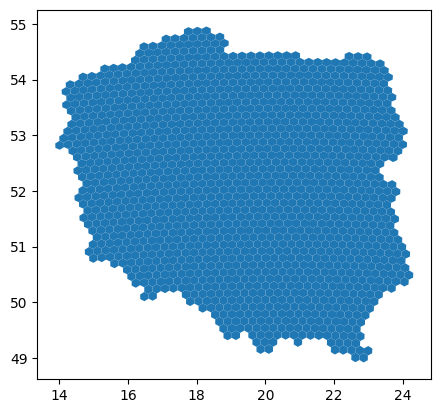

In [6]:
h3_gdf.plot()

In [7]:
# Convert back to WGS
h3_gdf2 = h3_gdf.to_crs('4236')

<Axes: >

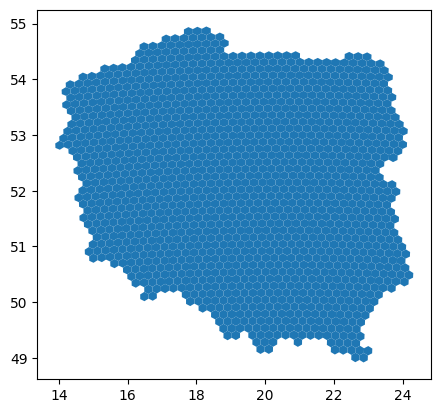

In [8]:
h3_gdf2.plot()

In [9]:
h3_gdf2.to_file("C:/Users/alkaye/geodemographics-demonstrator/processed_data/poland_h3_res5.geojson")